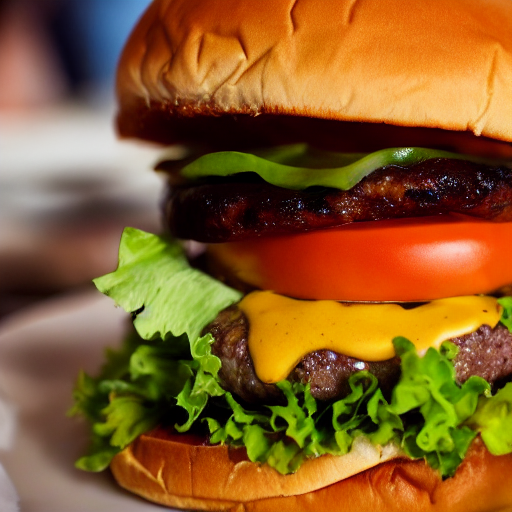

In [1]:
from typing import List
import torch
import numpy as np
from diffusers import StableDiffusionPipeline
# For video display:
from IPython.display import clear_output, display
from PIL import Image
from tqdm.auto import tqdm
from transformers import logging
import os

torch.manual_seed(1)

# Supress some unnecessary warnings when loading the CLIPTextModel
logging.set_verbosity_error()

# Set device
torch_device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
if "mps" == torch_device:
    os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = "1"
pipe = StableDiffusionPipeline.from_pretrained('runwayml/stable-diffusion-v1-5',
                                               torch_dtype=torch.float16).to(torch_device)

# Load the autoencoder model which will be used to decode the latents into image space.
vae = pipe.vae

# Load the tokenizer and text encoder to tokenize and encode the text.
tokenizer = pipe.tokenizer
text_encoder = pipe.text_encoder

# The UNet model for generating the latents.
unet = pipe.unet

# To the GPU we go!
vae = vae.to(torch_device)
text_encoder = text_encoder.to(torch_device)
unet = unet.to(torch_device)


def get_embeddings(prompts: List[str]) -> torch.Tensor:
    batch_size = len(prompts)
    text_input = tokenizer(prompts, padding="max_length", max_length=tokenizer.model_max_length, truncation=True,
                           return_tensors="pt")
    with torch.no_grad():
        text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]
    max_length = text_input.input_ids.shape[-1]
    uncond_input = tokenizer([""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt")
    with torch.no_grad():
        uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]
    text_embeddings = torch.cat([uncond_embeddings, text_embeddings])
    return text_embeddings


prompts = ["A high quality photo of a delicious burger"]
text_emb = get_embeddings(prompts)
batch_size = len(text_emb) // 2

beta_start, beta_end, num_train_steps = 0.00085, 0.012, 1000
betas = torch.linspace(beta_start**0.5, beta_end**0.5, num_train_steps)**2
alphas = 1.0 - betas
alpha_bars = alphas.cumprod(0)

# EDM
scales = alpha_bars**0.5
stds = (1.0 - alpha_bars)**0.5
sigmas = stds / scales


def interp(val, x):
    return torch.tensor(np.interp(x, torch.arange(val.shape[0]), val))


def interp_unit(val, t):
    return interp(val, t * num_train_steps)


@torch.no_grad()
def pred_noise(x, t, text_emb, guidance_scale=7.5):
    x = torch.cat([x] * 2)
    noise_pred = unet(x, t, encoder_hidden_states=text_emb).sample
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
    return noise_pred


def score_fn(x, t, text_emb, guidance_scale=7.5):
    return -pred_noise(x, t, text_emb, guidance_scale) / interp(stds, t)


def display_image(latents):
    with torch.no_grad():
        image = vae.decode((1 / 0.18215 * latents).half()).sample

    # Display
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    display(pil_images[0])


num_inference_steps = 100
increment = num_train_steps / num_inference_steps

generator = torch.manual_seed(32)
latents = torch.randn((batch_size, 4, 64, 64), generator=generator).half().to(torch_device) * interp_unit(sigmas, 1.0)


def update_latents(latents, i):
    sigma, sigma_p = interp(sigmas, i * increment), interp(sigmas, (i + 1) * increment)
    dsigma = sigma - sigma_p

    # First order
    latents_in = latents / ((sigma_p**2 + 1)**0.5)
    noise_pred = pred_noise(latents_in, (i + 1) * increment, text_emb)
    return noise_pred * dsigma


# Sampling loop
for i in tqdm(np.flip(np.arange(num_inference_steps))):
    latents = latents + update_latents(latents, i)
    if i % 10 == 0:
        clear_output()
        display_image(latents)

In [8]:
# from typing import List
# import torch
# import numpy as np
# from diffusers import StableDiffusionPipeline
# # For video display:
# from IPython.display import clear_output, display
# from PIL import Image
# from tqdm.auto import tqdm
# from transformers import logging
# import os

# torch.manual_seed(1)

# # Supress some unnecessary warnings when loading the CLIPTextModel
# logging.set_verbosity_error()

# # Set device
# torch_device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
# if "mps" == torch_device:
#     os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = "1"
# pipe = StableDiffusionPipeline.from_pretrained('runwayml/stable-diffusion-v1-5',
#                                                torch_dtype=torch.float16).to(torch_device)

# # Load the autoencoder model which will be used to decode the latents into image space.
# vae = pipe.vae

# # Load the tokenizer and text encoder to tokenize and encode the text.
# tokenizer = pipe.tokenizer
# text_encoder = pipe.text_encoder

# # The UNet model for generating the latents.
# unet = pipe.unet

# # To the GPU we go!
# vae = vae.to(torch_device)
# text_encoder = text_encoder.to(torch_device)
# unet = unet.to(torch_device)


# def get_embeddings(prompts: List[str]) -> torch.Tensor:
#     batch_size = len(prompts)
#     text_input = tokenizer(prompts, padding="max_length", max_length=tokenizer.model_max_length, truncation=True,
#                            return_tensors="pt")
#     with torch.no_grad():
#         text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]
#     max_length = text_input.input_ids.shape[-1]
#     uncond_input = tokenizer([""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt")
#     with torch.no_grad():
#         uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]
#     text_embeddings = torch.cat([uncond_embeddings, text_embeddings])
#     return text_embeddings


# prompts = ["A high quality photo of a delicious burger"]
# text_emb = get_embeddings(prompts)
# batch_size = len(text_emb) // 2

# beta_start, beta_end, num_train_steps = 0.00085, 0.012, 1000
# betas = torch.linspace(beta_start**0.5, beta_end**0.5, num_train_steps)**2
# alphas = 1.0 - betas
# alpha_bars = alphas.cumprod(0)

# # EDM
# scales = alpha_bars**0.5
# stds = (1.0 - alpha_bars)**0.5
# sigmas = stds / scales


# def interp(val, x):
#     return torch.tensor(np.interp(x, torch.arange(val.shape[0]), val))


# def interp_unit(val, t):
#     return interp(val, t * num_train_steps)


# @torch.no_grad()
# def pred_noise(x, t, text_emb, guidance_scale=7.5):
#     x = torch.cat([x] * 2)
#     noise_pred = unet(x, t, encoder_hidden_states=text_emb).sample
#     noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
#     noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
#     return noise_pred


# def score_fn(x, t, text_emb, guidance_scale=7.5):
#     return -pred_noise(x, t, text_emb, guidance_scale) / interp(stds, t)

# def flatten_score_fn(x, t, text_emb, guidance_scale=7.5):
#     x = x.reshape(1, 4, 64, 64)
#     x = torch.cat([x] * 2)
#     noise_pred = unet(x, t, encoder_hidden_states=text_emb).sample
#     noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
#     noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
#     noise_pred = (-noise_pred / interp(stds, t)).reshape(-1)
#     return noise_pred

# #     return (-pred_noise(x, t, text_emb, guidance_scale) / interp(stds, t)).reshape(-1)

# def display_image(latents):
#     with torch.no_grad():
#         image = vae.decode((1 / 0.18215 * latents).half()).sample

#     # Display
#     image = (image / 2 + 0.5).clamp(0, 1)
#     image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
#     images = (image * 255).round().astype("uint8")
#     pil_images = [Image.fromarray(image) for image in images]
#     display(pil_images[0])


# num_inference_steps = 100
# increment = num_train_steps / num_inference_steps

# generator = torch.manual_seed(32)
# latents = torch.randn((batch_size, 4, 64, 64), generator=generator).half().to(torch_device) * interp_unit(sigmas, 1.0)


# #     print(f"(1000-timestep.item())={(1000-timestep.item())} for hessian computation", flush=True)
# #     tic = time.time()
# #     H = torch.autograd.functional.jacobian(partial(self.flat_score_fn,t=t), x.reshape(-1)) # it takes 26 seconds to finish this
# #     H_eigvals, _ = torch.linalg.eigh(H)
# #     toc = time.time()

# #   def flat_score_fn(self, x, t):
# #     x = x.reshape(1, 3, 32, 32)
# #     return self.score_fn(x, t).reshape(-1)

# import pdb
# import time
# from functools import partial

# def update_latents(latents, i):
#     sigma, sigma_p = interp(sigmas, i * increment), interp(sigmas, (i + 1) * increment)
#     dsigma = sigma - sigma_p

#     # First order
#     latents_in = latents / ((sigma_p**2 + 1)**0.5)
#     noise_pred = pred_noise(latents_in, (i + 1) * increment, text_emb)
    
#     if i <= 100:
# #         breakpoint()
#         tic = time.time()
#         H = torch.autograd.functional.jacobian(partial(flatten_score_fn,t=(i + 1) * increment,text_emb=text_emb), latents_in.reshape(-1)) # it takes 26 seconds to finish this
# #         breakpoint()
#         H_eigvals, _ = torch.linalg.eig(H)
#         toc = time.time()

        

#     return noise_pred * dsigma


# # Sampling loop
# for i in tqdm(np.flip(np.arange(num_inference_steps))):
#     print(f"i={i}")
#     latents = latents + update_latents(latents, i)
#     if i % 10 == 0:
#         clear_output()
#         display_image(latents)

  0%|          | 0/100 [00:00<?, ?it/s]

i=99
> /state/partition1/job-41064381/ipykernel_3199591/2965370184.py(143)update_latents()
    141     if i <= 100:
    142         pdb.set_trace()
--> 143         tic = time.time()
    144         H = torch.autograd.functional.jacobian(partial(flatten_score_fn,t=(i + 1) * increment,text_emb=text_emb), latents_in.reshape(-1)) # it takes 26 seconds to finish this
    145         pdb.set_trace()



ipdb>  c


  0%|          | 0/100 [00:01<?, ?it/s]


RuntimeError: Expected is_sm80 || is_sm90 to be true, but got false.  (Could this error message be improved?  If so, please report an enhancement request to PyTorch.)

In [20]:
np.flip(np.arange(num_inference_steps))

array([99, 98, 97, 96, 95, 94, 93, 92, 91, 90, 89, 88, 87, 86, 85, 84, 83,
       82, 81, 80, 79, 78, 77, 76, 75, 74, 73, 72, 71, 70, 69, 68, 67, 66,
       65, 64, 63, 62, 61, 60, 59, 58, 57, 56, 55, 54, 53, 52, 51, 50, 49,
       48, 47, 46, 45, 44, 43, 42, 41, 40, 39, 38, 37, 36, 35, 34, 33, 32,
       31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15,
       14, 13, 12, 11, 10,  9,  8,  7,  6,  5,  4,  3,  2,  1,  0])

In [19]:
latents.shape

torch.Size([1, 4, 64, 64])